# Face Recogognition using PCA + SVM

In [5]:
%matplotlib inline  
import logging
from PIL import Image

from sklearn.decomposition import PCA
import os,sys
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from time import time
from sklearn.pipeline import Pipeline

## Read images

In [14]:
#path = '/home/ldarmet/Face recognition/CroppedYaleNoisy'
path = '/home/ldarmet/Face recognition/CroppedYale'
def read_images(path, sz=(168,192),occlusion = False): 
    t0 = time()
    c=0
    
    y = []
    X = np.empty([1, 32256]) #Image are resized to 168x192
    for dirname , dirnames , filenames in os.walk(path):
        for subdirname in dirnames:
            subject_path = os.path.join(dirname , subdirname) 
            for filename in os.listdir(subject_path):
                try:
                    im = Image.open(os.path.join(subject_path , filename)) 
                    im = im.convert("L")
                    # resize to given size (if given)
                    if (sz is not None):
                        im = im.resize(sz, Image.ANTIALIAS)
                    im  = np.asarray(im, dtype=np.uint8)
                    im.flags.writeable = True
                    
                    # Normalization
                    im = (im - im.mean())/im.std()

                    # Make occlusion great again
                    if occlusion:
                        im[30:60,10:150]=im.min()
                        im[70:100,60:100]=im.min()
                    
                    X = np.vstack((X,im.ravel()))
  
                    y.append(c)
                except IOError:
                    #print "I/O error({0}): {1}".format("errno", "strerror") #there is some text files in the path
                    pass
                except:
                    print "Unexpected error:", sys.exc_info()[0] 
                    raise
            c = c+1
        
    y = np.asarray(y)
    X = X[1::,:] # Skip the first line which is void
    print("Image read in %0.3fs" % (time() - t0))
    return [X,y]

## Occlusion example

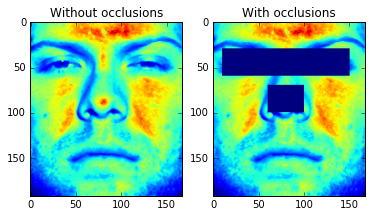

In [13]:
im = Image.open('/home/ldarmet/Face recognition/CroppedYale/yaleB01/yaleB01_P00A-005E+10.pgm') 
im = im.convert("L")
im = im.resize((168,192), Image.ANTIALIAS)

im  = np.asarray(im, dtype=np.uint8)
im.flags.writeable = True
im = (im - im.mean())/im.std()

fig = plt.figure()

ax1 = fig.add_subplot(121)
imgplot = plt.imshow(im)
plt.title('Without occlusion')

im_c = im.copy()
im_c[30:60,10:150]=im_c.min()
im_c[70:100,60:100]=im_c.min()
ax2 = fig.add_subplot(122)
plt.imshow(im_c)
plt.title('With occlusions')

## Train test split

In [15]:
%%time
X,y = read_images(path=path,occlusion=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

/home/ldarmet/.local/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in divide


Image read in 134.917s
CPU times: user 1min 30s, sys: 43.5 s, total: 2min 14s
Wall time: 2min 15s


## Pipeline and CV

A GridSearch is done over PCA number of components, C and Gamma for our SVM. Be patient !

In [ ]:
%%time
pipe = Pipeline([
    ('reduce_dim', PCA(svd_solver='randomized',
      whiten=True)),
    ('classify', SVC(kernel='rbf', class_weight='balanced'))
])

N_FEATURES_OPTIONS = range(150,250,50)
C_OPTIONS = [1e3, 5e3, 1e4, 5e4, 1e5]
gamma_OPTIONS = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]
        
param_grid = [
    {
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS,
        'classify__gamma' : gamma_OPTIONS
    }]

grid = GridSearchCV(pipe, cv=3, n_jobs= -1,param_grid=param_grid)
grid = grid.fit(X_train, y_train)
print("Best estimator found by grid search:")
print(grid.best_estimator_)
print '-----------------------------------------------------------------------'
print 'Best score found with the grid search (CV 3 folds)', grid.best_score_
print '-----------------------------------------------------------------------'


## Quantitative evaluation of the model quality on the test set

In [5]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = grid.predict(X_test)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred))

Predicting people's names on the test set
done in 0.655s
             precision    recall  f1-score   support

          0       0.89      1.00      0.94        16
          1       1.00      0.96      0.98        24
          2       1.00      0.95      0.97        20
          3       0.97      1.00      0.98        28
          4       0.97      1.00      0.98        29
          5       1.00      1.00      1.00        21
          6       1.00      1.00      1.00        24
          7       1.00      1.00      1.00        24
          8       1.00      0.96      0.98        24
          9       0.96      1.00      0.98        23
         10       1.00      0.95      0.97        19
         11       1.00      0.88      0.93        16
         12       1.00      0.96      0.98        25
         13       0.88      0.94      0.91        16
         14       0.96      1.00      0.98        22
         15       0.93      1.00      0.97        14
         16       1.00      0.96      0.9

Our results seem very very good : 96% on CV and 97% and our test set.

As the article suggests that sparsity is very good for face recognition tasks and as SVM is very sparse (only support vectors are taken in account to build class boundaries) it's not very surprising. What is more surprinsing is that we choose a standard EigenFaces for features extraction and it seems to be enough. 

However we loose in explainability and we haven't any metrics to reject invalid images. 

## Confusion Matrix on test set

In [ ]:
class_names = range(0,38,1)
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()